# Case study in support ticket resolution

### Ramanujan, Sanjay: E-89 course
sramanujan1@gmail.com 

In [1]:
import keras
print(keras.__version__)

Using TensorFlow backend.


2.2.4


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Dense

# fix random seed for reproducibility
seed = 2019
np.random.seed(seed)


### Dataset analysis

In [3]:
# use pandas to load the data and observe the top few rows
data = pd.read_csv("./supportcasesdata.csv")
print(data.shape)

(95245, 20)


In [4]:
# select columns of interest
dataset = data[[
                "ResolutionTime",
                "Title", 
                "Process", 
                "ServiceTeam",
                "IsCrucial", 
                "IsGradient", 
                "IsResearch", "IsFaulty","IsAvailable","IsLowCost",
               "DevelopmentType", "Geo","Org","ElecType", 
               "PlanType","IsUseful","Customer","DeveloperName","RegularType"
               ,"StackTrace"
               ]]

dataset[~dataset.isin(['NaN', 'NaT']).any(axis=1)]
dataset.dropna()
dataset = dataset[~dataset[dataset.columns.values].isnull()]
print(dataset.shape)

(95245, 20)


In [5]:
from pandas.api.types import CategoricalDtype

# fix empty values
dataset['IsGradient'].replace(to_replace=np.nan,
                               value = 10.0,
                               inplace = True
                              )

dataset['DevelopmentType'].replace(to_replace=np.nan,
                               value = "unknown",
                               inplace = True
                              )

dataset['Geo'].replace(to_replace=np.nan,
                               value = "unknown",
                               inplace = True
                              )

dataset['Org'].replace(to_replace=np.nan,
                               value = "unknown",
                               inplace = True
                              )

dataset['ElecType'].replace(to_replace=np.nan,
                               value = "unknown",
                               inplace = True
                              )

dataset['PlanType'].replace(to_replace=np.nan,
                               value = "unknown",
                               inplace = True
                              )

dataset['DeveloperName'].replace(to_replace=np.nan,
                               value = "unknown",
                               inplace = True
                              )

dataset['RegularType'].replace(to_replace=np.nan,
                               value = False,
                               inplace = True
                              )
# convert datasets
dataset['IsGradient'] = dataset['IsGradient'].astype('category')
dataset['IsUseful'] = dataset['IsUseful'].astype('category')
dataset['IsResearch'] = dataset['IsResearch'].astype('category')
dataset['IsFaulty'] = dataset['IsFaulty'].astype('category')
dataset['IsAvailable'] = dataset['IsAvailable'].astype('category')
dataset['IsLowCost'] = dataset['IsLowCost'].astype('category')

dataset_fixed = dataset
dataset_binarize = dataset
print(dataset_binarize.dtypes)

ResolutionTime       object
Title                object
Process              object
ServiceTeam          object
IsCrucial             int64
IsGradient         category
IsResearch         category
IsFaulty           category
IsAvailable        category
IsLowCost          category
DevelopmentType      object
Geo                  object
Org                  object
ElecType             object
PlanType             object
IsUseful           category
Customer             object
DeveloperName        object
RegularType            bool
StackTrace           object
dtype: object


### We replace values with encoding that allow us to feed data into ML models

In [6]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer, MultiLabelBinarizer

#Step 1: Generate numerical codes for each column
def LabelCodingData(df):
        columnsToEncode = list(df.select_dtypes(include=['category','object', 'int64']))
        le = LabelEncoder()
        for feature in columnsToEncode:
            try:
                df[feature] = le.fit_transform(df[feature])
            except:
                print('Error encoding ', feature)
        return df

dataset = LabelCodingData(dataset_fixed)    
print(dataset.dtypes)


ResolutionTime     int64
Title              int64
Process            int64
ServiceTeam        int64
IsCrucial          int64
IsGradient         int64
IsResearch         int64
IsFaulty           int64
IsAvailable        int64
IsLowCost          int64
DevelopmentType    int64
Geo                int64
Org                int64
ElecType           int64
PlanType           int64
IsUseful           int64
Customer           int64
DeveloperName      int64
RegularType         bool
StackTrace         int64
dtype: object


In [7]:
# remove this objective function from feature dataset or we will get 99%+ prediction :-) 

labels = np.array(dataset["ResolutionTime"])

features= dataset.drop("ResolutionTime", axis = 1)

#save feature list
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)


In [9]:
# Prepare the data 
# Splitting the dataset into the Training set and Test set (80/20)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, random_state=2019)

print("X_train.shape: ", X_train.shape)
print("X_test.shape: ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

X_train.shape:  (76196, 19)
X_test.shape:  (19049, 19)
y_train:  (76196,)
y_test:  (19049,)


### At first pass, we analyze the features for variable importance

In [10]:
from sklearn.ensemble import RandomForestClassifier

# Create a Gaussian classifier
model = RandomForestClassifier(n_estimators=500, random_state = 2019)

# Train the model 
model.fit(X_train,y_train)
#score = model.score(X_train, y_train)

# predict on holdout and get feature importance
#y_pred = model.predict(X_test)
print(model.feature_importances_)

C:\Users\sanram\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


[0.19998142 0.0857499  0.15225159 0.01841251 0.03733814 0.01079126
 0.05739732 0.01295006 0.01084953 0.05695257 0.01218801 0.01300408
 0.01471953 0.14938118 0.01130902 0.01329426 0.02288807 0.01212475
 0.1084168 ]


In [11]:
# Get numerical feature importances
importances = list(model.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

#print(feature_importances)

Variable: Title                Importance: 0.2
Variable: ServiceTeam          Importance: 0.15
Variable: PlanType             Importance: 0.15
Variable: StackTrace           Importance: 0.11
Variable: Process              Importance: 0.09
Variable: IsFaulty             Importance: 0.06
Variable: DevelopmentType      Importance: 0.06
Variable: IsGradient           Importance: 0.04
Variable: IsCrucial            Importance: 0.02
Variable: DeveloperName        Importance: 0.02
Variable: IsResearch           Importance: 0.01
Variable: IsAvailable          Importance: 0.01
Variable: IsLowCost            Importance: 0.01
Variable: Geo                  Importance: 0.01
Variable: Org                  Importance: 0.01
Variable: ElecType             Importance: 0.01
Variable: IsUseful             Importance: 0.01
Variable: Customer             Importance: 0.01
Variable: RegularType          Importance: 0.01


### Create a histogram illustrating feature importance to resolution time

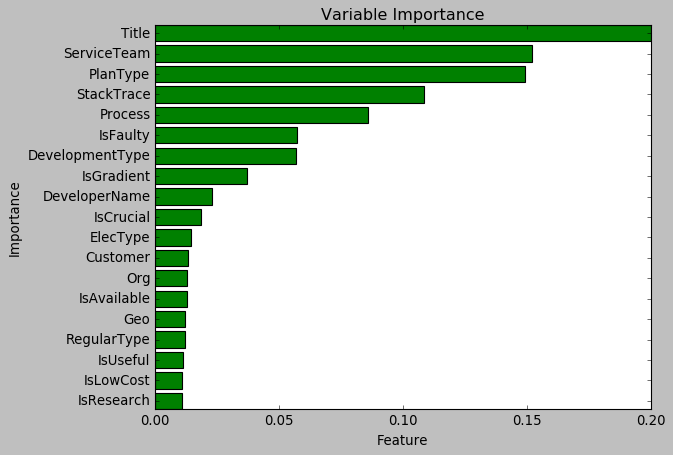

In [12]:
# Import matplotlib for plotting 
from operator import itemgetter
import matplotlib.pyplot as plt
%matplotlib inline

# Set the style
#plt.style.use('fivethirtyeight')
#plt.style.use('seaborn-whitegrid')
plt.style.use('classic')

mydict = dict(zip(feature_list, importances))
mydict_sorted = sorted(mydict.items(), key=lambda x:x[1], reverse=True) # a list 

dfchart = pd.DataFrame(mydict_sorted)
dfchart.columns = ['Features', 'Importance']
dfchart = dfchart.sort_values(by='Importance', ascending=True)
#dfchart = dfchart.iloc[::-1]
#dfchart = dfchart.reset_index(inplace=False)

plt.barh(dfchart.Features, dfchart.Importance, height = 0.8, color = 'green', tick_label = dfchart.Features)
plt.yticks(dfchart.Features, dfchart.Features)

plt.ylabel('Importance'); plt.xlabel('Feature'); plt.title('Variable Importance');
plt.show()

### For curiosity and giggles, we use a traditional ML model such as xgboost to predict ML KPIs

In [50]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier(n_estimators = 2000, random_state = 2019)

# Train the model 
xgb_model.fit(X_train,y_train)
score = xgb_model.score(X_train, y_train)
xgb_y_pred = xgb_model.predict(X_test)

C:\Users\sanram\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\sanram\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [51]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test, xgb_y_pred, average='weighted')

(0.6552215855570523, 0.6533151346527377, 0.6539683145032534, None)

#### These features explain 65% of the reasons behind resolution time (not a bad start). We get almost equal precision and recall. The remaining features include data from stack trace exceptions that we can add into NN and see if this beats the traditional ML model. 


### 2. Use Deep Learning models for this prediction

In [6]:
# split the text
dataset['CleanedText'] = data['StackTrace'].str.replace('.', ' ')
dataset.tail(5)

,ResolutionTime,Title,Process,ServiceTeam,IsCrucial,IsGradient,IsResearch,IsFaulty,IsAvailable,IsLowCost,...,Geo,Org,ElecType,PlanType,IsUseful,Customer,DeveloperName,RegularType,StackTrace,CleanedText
95240,Enormous,H167A,R489I87F,76IK112C,0,10.0,0,0,0,0,...,EXL,XYZ,789ZYX,T370K187H,0,65J754,I123H681,False,2579ZHA 827262QRI 218635QHE,2579ZHA 827262QRI 218635QHE
95241,Low,H167A,R22S77J,76IK112C,0,10.0,0,0,0,0,...,NQX,ABC,123ABC,X257QL25675,0,361Q690,J77I706,False,2579ZHA 827262QRI 218635QHE,2579ZHA 827262QRI 218635QHE
95242,High,M102,D384E75X,76IK112C,0,50.0,0,0,1,0,...,EXL,XYZ,123ABC,R124SJ106685,0,65J754,I123H681,True,2579ZHA 827262QRI 218635QHE,2579ZHA 827262QRI 218635QHE
95243,Low,K457,Z68H68A,180EF447Y,0,50.0,0,0,1,0,...,EXL,XYZ,123ABC,S246JG84758,1,65J754,I123H681,True,2579ZHA 827262QRI 218635QHE,2579ZHA 827262QRI 218635QHE
95244,Enormous,B339,D384E75X,362GZ92W,1,10.0,0,0,0,0,...,EXL,XYZ,123ABC,W324XQ179652,0,65J754,I123H681,False,2579ZHA 827262QRI 218635QHE,2579ZHA 827262QRI 218635QHE


In [7]:
from keras.preprocessing.text import one_hot,Tokenizer
from keras.preprocessing.sequence import pad_sequences

# create our corpus list from this cleaned text
corp = []
for row in dataset['CleanedText']:
    corp.append(row)


no_docs=len(corp)
print(no_docs) 
#corp

95245


#### We implement a tokenizer using Keras API

In [8]:
# implement tokenizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence

tokens = []
for row in dataset['CleanedText']:
    word_seq = text_to_word_sequence(row)
    tokens.append(word_seq)

print(len(tokens))
type(tokens)
#tokens

95245


list

In [9]:
from keras.preprocessing.text import Tokenizer
# create the tokenizer
t = Tokenizer()
# fit the tokenizer on the documents
t.fit_on_texts(dataset['CleanedText'])

In [10]:
# http://faroit.com/keras-docs/1.2.2/preprocessing/text/
# summarize what was learned
print("Word counts: ", len(t.word_counts))
print("\n")
print("Word index: ", len(t.word_index))
print("\n")
print("Word docs: " , len(t.word_docs))
print("\n")

Word counts:  263


Word index:  263


Word docs:  263




In [11]:
# estimate the size of the vocabulary
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import one_hot

vocab_size=len(t.word_counts)*1.2  
encod_corp=[]
for i,doc in enumerate(corp):
    encod_corp.append(one_hot(doc,vocab_size))
#    print("The encoding for document",i+1," is : ",one_hot(doc,vocab_size))


In [12]:
# length of maximum document. will be nedded whenever create embeddings for the words
maxlen=-1
for doc in corp:
#    tokens=nltk.word_tokenize(doc)
    tokens = text_to_word_sequence(doc)
    if(maxlen<len(tokens)):
        maxlen=len(tokens)
print("The maximum number of words in any document is : ",maxlen)

The maximum number of words in any document is :  8


### We create padding to allow us to have each record with same number of tokens

In [13]:
# now to create embeddings all of our docs need to be of same length. hence we can pad the docs with zeros.
from keras.preprocessing.sequence import pad_sequences
pad_corp=pad_sequences(encod_corp,maxlen=maxlen,padding='post',value=0.0)
print("No of padded documents: ",len(pad_corp))

No of padded documents:  95245


In [14]:
print(pad_corp.shape)
type(pad_corp)

(95245, 8)


numpy.ndarray

In [15]:
### use one hot encoding for neural network based models
# we simply use LabelBinarizer to perform one hot encoding in one step
from sklearn.preprocessing import LabelBinarizer
df_nn = pd.DataFrame()
print(dataset_binarize.shape)

Process_nn = LabelBinarizer().fit_transform(dataset_binarize['Process'])
print(Process_nn.shape)
print(type(Process_nn))

Title_nn = LabelBinarizer().fit_transform(dataset_binarize['Title'])
print(Title_nn.shape)

ServiceTeam_nn = LabelBinarizer().fit_transform(dataset_binarize['ServiceTeam'])
print(ServiceTeam_nn.shape)

IsCrucial_nn = LabelBinarizer().fit_transform(dataset_binarize['IsCrucial'])
print(IsCrucial_nn.shape)

IsGradient_nn = LabelBinarizer().fit_transform(dataset_binarize['IsGradient'])
print(IsGradient_nn.shape)

DevelopmentType_nn = LabelBinarizer().fit_transform(dataset_binarize['DevelopmentType'])
print(DevelopmentType_nn.shape)

Geo_nn = LabelBinarizer().fit_transform(dataset_binarize['Geo'])
print(Geo_nn.shape)

Org_nn = LabelBinarizer().fit_transform(dataset_binarize['Org'])
print(Org_nn.shape)

ElecType_nn = LabelBinarizer().fit_transform(dataset_binarize['ElecType'])
print(ElecType_nn.shape)

PlanType_nn = LabelBinarizer().fit_transform(dataset_binarize['PlanType'])
print(PlanType_nn.shape)

IsUseful_nn = LabelBinarizer().fit_transform(dataset_binarize['IsUseful'])
print(IsUseful_nn.shape)

Customer_nn = LabelBinarizer().fit_transform(dataset_binarize['Customer'])
print(Customer_nn.shape)

DeveloperName_nn = LabelBinarizer().fit_transform(dataset_binarize['DeveloperName'])
print(DeveloperName_nn.shape)

RegularType_nn = LabelBinarizer().fit_transform(dataset_binarize['RegularType'])
print(RegularType_nn.shape)

IsResearch_nn = LabelBinarizer().fit_transform(dataset_binarize['IsResearch'])
print(IsResearch_nn.shape)

IsFaulty_nn = LabelBinarizer().fit_transform(dataset_binarize['IsFaulty'])
print(IsFaulty_nn.shape)

IsAvailable_nn = LabelBinarizer().fit_transform(dataset_binarize['IsAvailable'])
print(IsAvailable_nn.shape)

IsLowCost_nn = LabelBinarizer().fit_transform(dataset_binarize['IsLowCost'])
print(IsLowCost_nn.shape)


df_nn = np.concatenate([Title_nn, Process_nn,ServiceTeam_nn,IsCrucial_nn,IsGradient_nn,
                        DevelopmentType_nn, Geo_nn, Org_nn, ElecType_nn,
                        IsResearch_nn, IsFaulty_nn, IsAvailable_nn, IsLowCost_nn, pad_corp,
                        PlanType_nn, IsUseful_nn, Customer_nn, DeveloperName_nn, RegularType_nn], axis=1)

print(df_nn.shape)
print(type(dataset_binarize['ResolutionTime']))
print(type(df_nn))

labels_nn = np.array(dataset_binarize['ResolutionTime'])
features_nn = np.array(df_nn)

print(type(labels_nn))
print(features_nn.shape[1])
print(labels_nn)

(95245, 21)
(95245, 116)
<class 'numpy.ndarray'>
(95245, 872)
(95245, 220)
(95245, 1)
(95245, 4)
(95245, 38)
(95245, 3)
(95245, 3)
(95245, 3)
(95245, 55)
(95245, 3)
(95245, 11)
(95245, 9)
(95245, 1)
(95245, 1)
(95245, 1)
(95245, 1)
(95245, 1)
(95245, 1351)
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
1351
['Low' 'Enormous' 'Medium' ... 'High' 'Low' 'Enormous']


### We once again set aside data for train and test using scikit learn libraries

In [24]:
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(features_nn, labels_nn, test_size = 0.2, random_state=2019)

# Alternatively
#X_val = X[:2000]
#X_train = X[8000:]
#Y_val = y[:2000]
#partial_Y_train = y[2000:]

print("X_train.shape: ", X_train_nn.shape)
print("X_test.shape: ", X_test_nn.shape)
print("y_train: ", y_train_nn.shape)
print("y_test: ", y_test_nn.shape)
y_test_nn

X_train.shape:  (76196, 1351)
X_test.shape:  (19049, 1351)
y_train:  (76196,)
y_test:  (19049,)


array([2, 2, 0, ..., 1, 0, 2], dtype=int64)

In [25]:
#Initializing Neural Network
import keras
from keras import models
from keras import layers
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.embeddings import Embedding
from keras.layers import GRU

### Experimented with DNN, GRU and eventually settled with an Embedding Layer and outputting using a softmax function for this multiclass problem

In [35]:
import keras_metrics as km
sc_precision = km.sparse_categorical_precision()
sc_recall = km.sparse_categorical_recall()

# build model
EMBEDDING_DIM = 25 

model = models.Sequential()

#model.add(layers.Dense(1024, activation='relu',
#                           input_shape=(X_train_nn.shape[1],)))
#model.add(layers.Dense(512, activation='relu'))
#model.add(layers.Dense(128, activation='sigmoid'))

model.add(Embedding(10000, EMBEDDING_DIM, input_length=features_nn.shape[1]))
model.add(Flatten())
#model.add(GRU(units=32, dropout=0.2, recurrent_dropout = 0.2))
#model.add(GRU(32, return_sequences=False))
model.add(layers.Dense(4, activation='softmax')) # multiclass with 4 outputs 


In [ ]:
# use two approaches for accuracy, precision-recall metrics 

# model.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=[sc_precision, sc_recall])

model.summary()

In [27]:
#Fitting the model
# Typically we choose epochs * batch_size >= total_params 

from keras.callbacks import History 

history = model.fit(X_train_nn,
                    y_train_nn,
                    epochs=100,
                    batch_size=5000,
                    validation_data=(X_test_nn, y_test_nn))

print("dict for history: ", history.history.keys())

Train on 76196 samples, validate on 19049 samples
Epoch 1/100
76196/76196 [==============================] - 10s 135us/step - loss: 1.4578 - acc: 0.2725 - val_loss: 1.3691 - val_acc: 0.3908
Epoch 2/100
76196/76196 [==============================] - 9s 123us/step - loss: 1.3659 - acc: 0.3730 - val_loss: 1.3444 - val_acc: 0.3759
Epoch 3/100
76196/76196 [==============================] - 9s 118us/step - loss: 1.3225 - acc: 0.3985 - val_loss: 1.3002 - val_acc: 0.4035
Epoch 4/100
76196/76196 [==============================] - 9s 116us/step - loss: 1.2801 - acc: 0.4094 - val_loss: 1.2623 - val_acc: 0.4058
Epoch 5/100
76196/76196 [==============================] - 9s 117us/step - loss: 1.2444 - acc: 0.4177 - val_loss: 1.2315 - val_acc: 0.4300
Epoch 6/100
76196/76196 [==============================] - 9s 115us/step - loss: 1.2103 - acc: 0.4483 - val_loss: 1.1974 - val_acc: 0.4620
Epoch 7/100
76196/76196 [==============================] - 9s 116us/step - loss: 1.1758 - acc: 0.4799 - val_loss: 1

### Training and validation loss

range(1, 101)


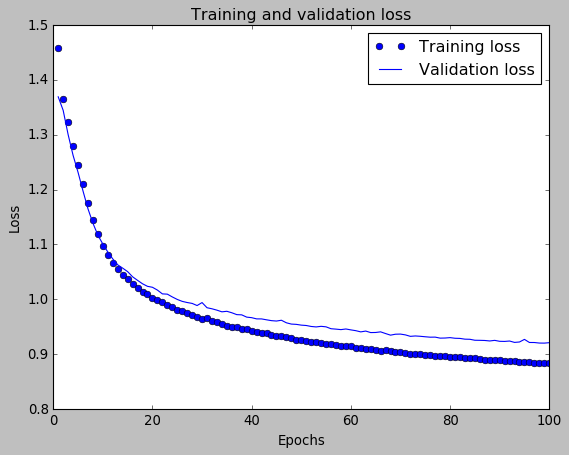

In [28]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

#prec = history.history['precision']
#val_prec = history.history['val_precision']

#recall = history.history['recall']
#val_recall = history.history['val_recall']

epochs = range(1, len(acc) + 1)
print(epochs)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

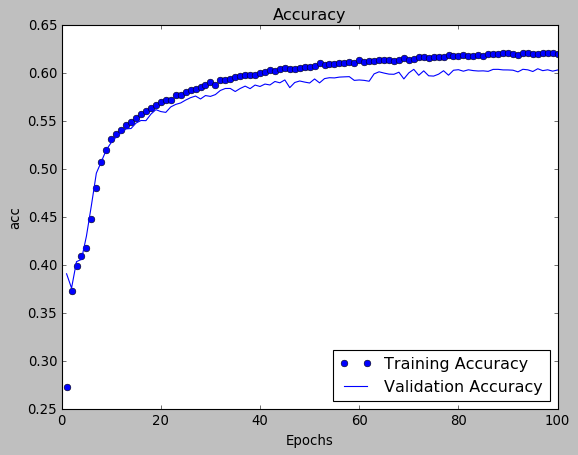

In [34]:
#history_dict = history.history
plt.clf()   # clear figure
#plt.plot(epochs, mae, 'bo', label='Training mae')
#plt.plot(epochs, val_mae, 'b', label='Validation mae')
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
#plt.plot(epochs, rsq, 'bo', label='Training R-Square')
#plt.plot(epochs, val_rsq, 'b', label='Validation R-Square')

#plt.plot(epochs, prec, 'bo', label='Training Precision')
#plt.plot(epochs, val_prec, 'b', label='Validation Precision')

#plt.plot(epochs, recall, 'bo', label='Training Recall')
#plt.plot(epochs, val_recall, 'b', label='Validation Recall')

plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend(loc='lower right')

plt.show()

In [39]:
import keras_metrics as km
sc_precision = km.sparse_categorical_precision()
sc_recall = km.sparse_categorical_recall()

# build model
EMBEDDING_DIM = 25 

model = models.Sequential()

#model.add(layers.Dense(1024, activation='relu',
#                           input_shape=(X_train_nn.shape[1],)))
#model.add(layers.Dense(512, activation='relu'))
#model.add(layers.Dense(128, activation='sigmoid'))

model.add(Embedding(10000, EMBEDDING_DIM, input_length=features_nn.shape[1]))
model.add(Flatten())
#model.add(GRU(units=32, dropout=0.2, recurrent_dropout = 0.2))
#model.add(GRU(32, return_sequences=False))
model.add(layers.Dense(4, activation='softmax')) # multiclass with 4 outputs 


In [40]:
# using precision reacll metrics
# use two approaches for accuracy, precision-recall metrics 

# model.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=[sc_precision, sc_recall])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1351, 25)          250000    
_________________________________________________________________
flatten_3 (Flatten)          (None, 33775)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 135104    
Total params: 385,104
Trainable params: 385,104
Non-trainable params: 0
_________________________________________________________________


In [41]:
#Fitting the model
# Typically we choose epochs * batch_size >= total_params 

from keras.callbacks import History 

history = model.fit(X_train_nn,
                    y_train_nn,
                    epochs=100,
                    batch_size=5000,
                    validation_data=(X_test_nn, y_test_nn))

print("dict for history: ", history.history.keys())

Train on 76196 samples, validate on 19049 samples
Epoch 1/100
76196/76196 [==============================] - 9s 119us/step - loss: 1.4356 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3967 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
76196/76196 [==============================] - 9s 121us/step - loss: 1.3672 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3477 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
76196/76196 [==============================] - 12s 154us/step - loss: 1.3284 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3064 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
76196/76196 [==============================] - 9s 117us/step - loss: 1.2873 - precision: 0.6891 - recall: 0.0813 - val_loss: 1.2694 - val_precision: 0.6367 - val_recall: 0.2378
Epoch 5/100
76196/76196 [==============================] - 10s 128us/step - loss: 1.2528 - precision: 0.6055 - recall: 0.2359 - val_loss: 1.2371 

76196/76196 [==============================] - 9s 120us/step - loss: 0.8908 - precision: 0.7858 - recall: 0.5634 - val_loss: 0.9266 - val_precision: 0.7652 - val_recall: 0.5501
Epoch 87/100
76196/76196 [==============================] - 10s 127us/step - loss: 0.8904 - precision: 0.7889 - recall: 0.5624 - val_loss: 0.9245 - val_precision: 0.7761 - val_recall: 0.5435
Epoch 88/100
76196/76196 [==============================] - 9s 123us/step - loss: 0.8894 - precision: 0.7908 - recall: 0.5611 - val_loss: 0.9240 - val_precision: 0.7797 - val_recall: 0.5323
Epoch 89/100
76196/76196 [==============================] - 9s 121us/step - loss: 0.8892 - precision: 0.7921 - recall: 0.5576 - val_loss: 0.9246 - val_precision: 0.7789 - val_recall: 0.5304
Epoch 90/100
76196/76196 [==============================] - 9s 123us/step - loss: 0.8887 - precision: 0.7866 - recall: 0.5631 - val_loss: 0.9238 - val_precision: 0.7934 - val_recall: 0.5193
Epoch 91/100
76196/76196 [==============================] - 9s

### Precision and Recall metrics

range(1, 101)


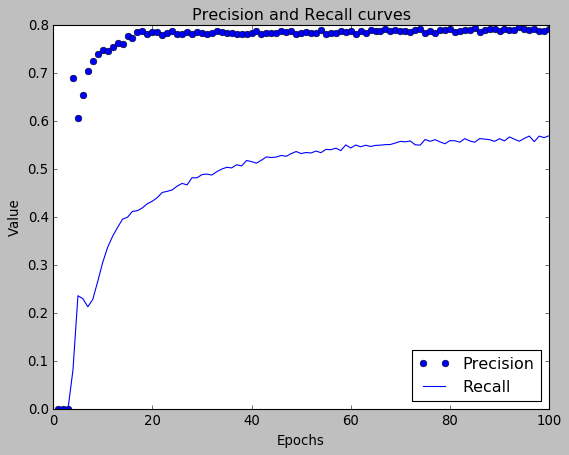

In [45]:
import matplotlib.pyplot as plt

#acc = history.history['acc']
#val_acc = history.history['val_acc']

#loss = history.history['loss']
#val_loss = history.history['val_loss']

prec = history.history['precision']
val_prec = history.history['val_precision']

recall = history.history['recall']
val_recall = history.history['val_recall']

epochs = range(1, len(acc) + 1)
print(epochs)

# "bo" is for "blue dot"
plt.plot(epochs, prec, 'bo', label='Precision')
# b is for "solid blue line"
plt.plot(epochs, recall, 'b', label='Recall')
plt.title('Precision and Recall curves')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend(loc = 'lower right')

plt.show()

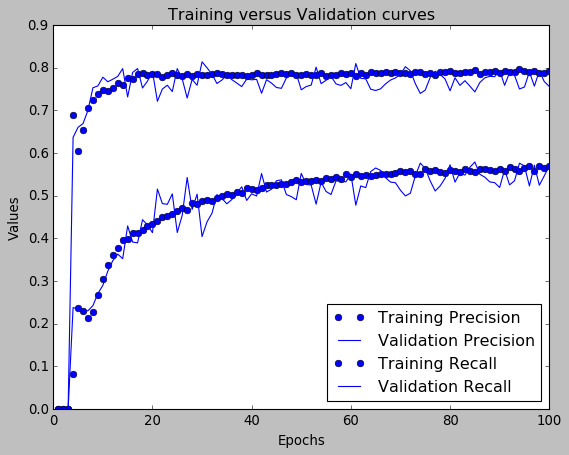

In [46]:
#history_dict = history.history
plt.clf()   # clear figure
#plt.plot(epochs, mae, 'bo', label='Training mae')
#plt.plot(epochs, val_mae, 'b', label='Validation mae')
#plt.plot(epochs, acc, 'bo', label='Training Accuracy')
#plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')

plt.plot(epochs, prec, 'bo', label='Training Precision')
plt.plot(epochs, val_prec, 'b', label='Validation Precision')

plt.plot(epochs, recall, 'bo', label='Training Recall')
plt.plot(epochs, val_recall, 'b', label='Validation Recall')

plt.title('Training versus Validation curves')
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.legend(loc='lower right')

plt.show()

### Did this beat the traditional ML model for text data prediction?  

### Just barely! We got higher precision but lower recall yielding an overall F1 score = 66.22% [ a harmonic mean of precision and recall = 2*p*r / (p+r) ] which just beat the traditional ML model that had an F1 score = 65.39%